<a href="https://colab.research.google.com/github/mahishahh/Anti-Icing-on-Aircraft-Wings/blob/main/Transport_Phenomena.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **<center>Transport Phenomena Project - Sky Sheild</center>**


This is a description of a model for anti-icing on surfaces. The model simulates the formation of a water film on a surface, and how aerodynamic forces cause the film to run back. This model treats runback water film layer and the air boundary layer as two related regions.

**Assumptions**
* the droplets remain spherical
* the droplets do not affect the flow field.



# **Mass and Energy Transport**

##Mass Transport Equations

For the control volume, the mass balance equation is:
$$
\dot{m}_{in} + \dot{m}_{imp} = \dot{m}_{out} + \dot{m}_{evap} \\
$$
Where:  
- $\dot{m}_{in}$ = inlet mass rate  
- $\dot{m}_{imp}$ = water droplet impingement mass rate  
- $\dot{m}_{out}$ = water outlet mass rate  
- $\dot{m}_{evap}$ = water evaporation mass rate<br>

The mass flow rate of water droplet impingement is calculated as:
$$
\dot{m}_{imp} = \overline{V} \beta A_{ht} \cdot LWC
$$
Where:  
- $A_{ht}$ = impingement surface area of the control
volume  
- $LWC$ = liquid water content
- ${\beta}$ = ratio of the area of impingement to the
area through which the water passes at some
distance upstream of the airfoil. <br>
$$
\dot{m}_{evap} = F A_{ht} \cdot 0.6221 h_{air} (P_{v,water} - P_{v,e})\\
$$
Where:  
- $P_{v}$ = local saturated vapor
pressure
- $P_{e}$ = local pressure
- $F$ = Wetness factor,
which was defined as the ratio of wet region
area to the total area<br>



## Heat / Energy Transport Equations



According to the energy conversation law, the
energy balance equation can be written as,
$$
\mathcal
{Q}_{anti-ice} + k_{wall}A_{wall}\frac{\partial^{2} T}{\partial s^{2}} + (1-F)r\frac{h_{air}v_{e}^{2}}{2c_{p,air}}A_{hi} = Fh_{water}A_{ht}(T_{wall}-T_{water}) + (1-F)h_{air}A_{ht}(T_{wall}-T_{rec}) \\
$$
Where:  
- $k_{wall}$ = thermal conductivity of the solid  
- $T_{rec}$ = air recovery
temperature
- $r$ = recovery factor
- $C_{p}$ = specific heat<br>

$T_{rec}$ can be calculated as follows:
$$
T_{rec} = (1-r)T_{e} + rT_{e}(1+\frac{k-1}{2}M_{e}^{2}) \\
$$
Where:  
- $k$ = ratio of specific heats<br>

Energy balance equation for the water
film can be given as:
$$
Fh_{water}A_{ht}(T_{wall}-T_{water}) + (\dot{m}_{in}c_{p,water}T_{water-in} - \dot{m}_{out}c_{p,water}T_{water-out}) + \dot{m}_{imp} [ \frac{v_{∞}^{2}}{2}A_{hi} - c_{p,water} (T_{water} - T_{water-in})] = Fh_{air}A_{ht}(T_{water}-T_{rec}) + \dot{m}_{evap} [ c_{p,water} (T_{water}-T_{water-ir}) + i]
$$
Where:  
- $T_{water-in}$ = water temperatures at the inlet
- $T_{water-out}$ = water temperatures at the outlet
- $T_{water}$ = average temperature of the water film on the surface
- $i$ = latent heat of water

$T_{water}$ is defined as,
$$
T_{water} =  \frac{(\dot{m}_{in}T_{water-in} + \dot{m}_{out}T_{water-out})}{\dot{m}_{water}}
$$
Where:  
- $\dot{m}_{water}$ = average mass of the water film on the surface
$$
\dot{m}_{water} =  \frac{\dot{m}_{in} + \dot{m}_{out}}{2}
$$

In the mass and energy equations,
convection heat transfer coefficients are needed.
They can be approximately got by using the
experiential expressions or obtained from the
results of CFD computation. For the leading
edge, the experienced convection heat transfer
coefficient can be calculated using the following
equation:
$$
Nu_D = \frac{hD}{k} = 1.14 Re_D^{0.5} Pr^{0.4} \left[1 - \left(\frac{\theta}{90}\right)^3\right] \quad (0 \leq \theta \leq 80°)
$$
Where:  
- $D$ = leading edge’s diameter

Nusselt number can be calculated using the following equation,
$$
Nu_s = 0.0296 Re_s^{0.8} Pr^{\frac{1}{3}}
$$
Where:  
- $s$ =  Curve length from the stagnation point to the local position

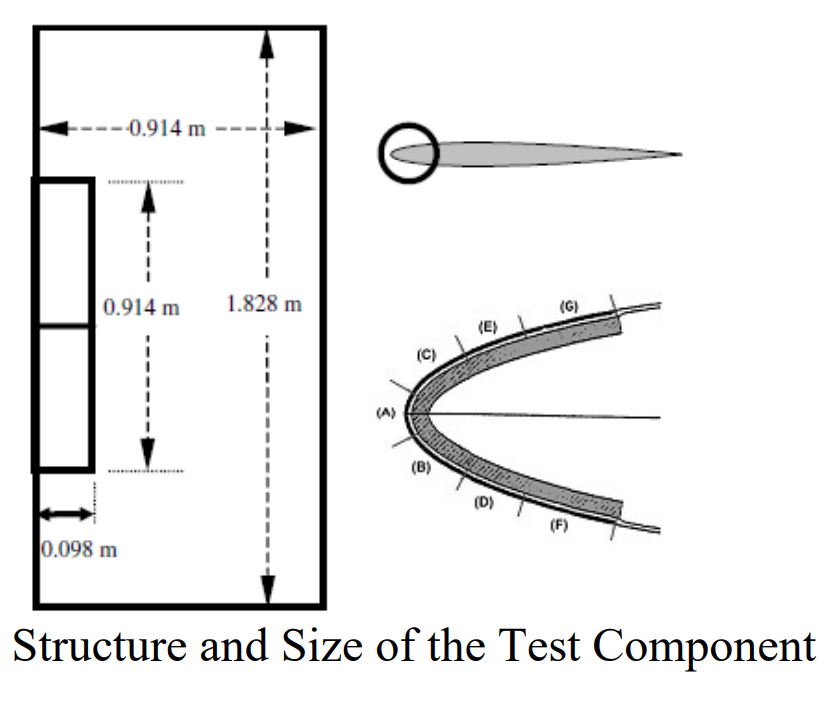

## Mass & Heat Transport Simulations

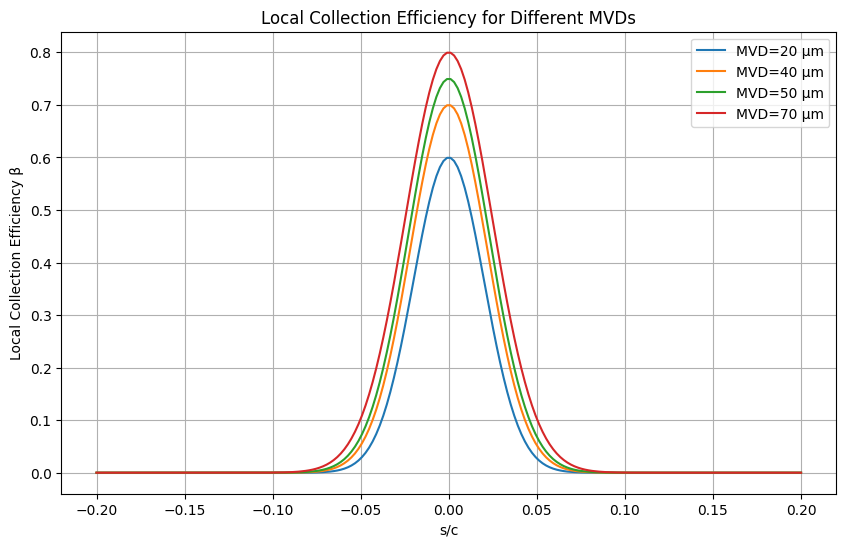

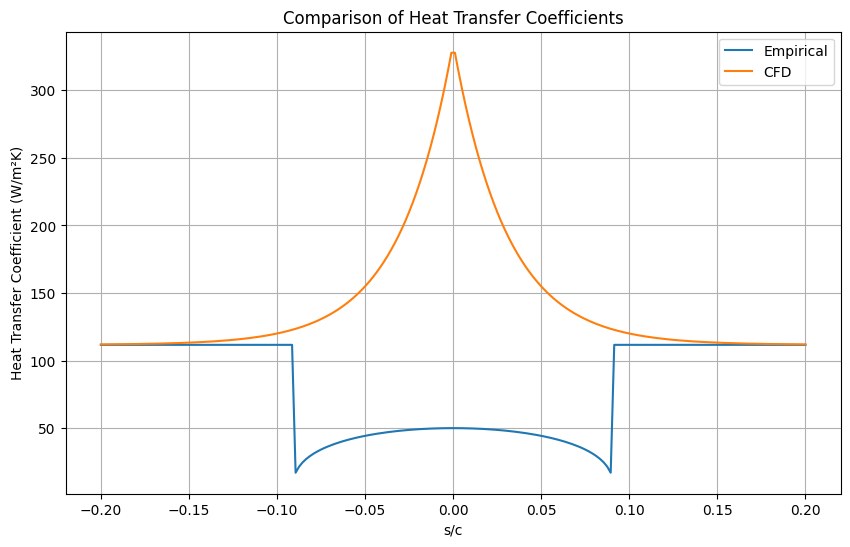

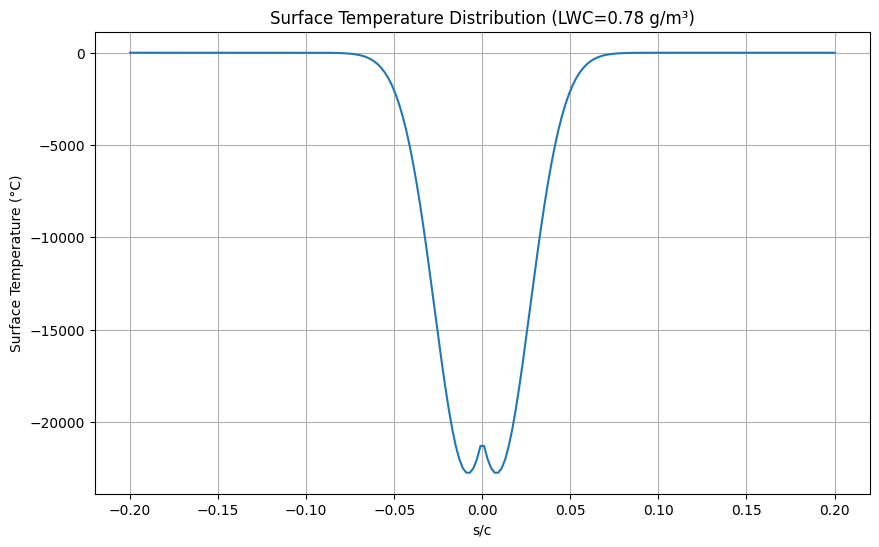

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

class AntiIcingAnalysis:
    def __init__(self):
        self.V_inf = 44.7  # m/s
        self.T_inf = -7.6 + 273.15  # K
        self.chord = 0.914  # m
        self.rho_air = 1.225  # kg/m^3
        self.mu_air = 1.789e-5  # kg/(m·s)

    def calculate_local_collection_efficiency(self, s, mvd):
        """Calculate local collection efficiency β for different MVDs"""
        s_norm = s / self.chord
        beta_max = {
            20: 0.6,
            40: 0.7,
            50: 0.75,
            70: 0.8
        }

        # Approximate beta distribution using normal distribution
        sigma = 0.02 + 0.0001 * mvd
        beta = beta_max[mvd] * np.exp(-(s_norm)**2 / (2*sigma**2))
        return beta

    def calculate_heat_transfer_coefficient(self, s, method='empirical'):
        """Calculate convective heat transfer coefficient"""
        s_norm = s / self.chord
        Re = self.rho_air * self.V_inf * self.chord / self.mu_air

        if method == 'empirical':
            if abs(s_norm) <= 0.1:  # Leading edge region
                Nu = 1.14 * Re**0.5 * (1 - (abs(s_norm)/0.1)**2)**0.34
            else:
                Nu = 0.0296 * Re**0.8
        else:  # CFD-based (approximated)
            Nu = 0.0296 * Re**0.8 * (1 + 2*np.exp(-30*abs(s_norm)))

        k_air = 0.024  # W/(m·K)
        h = Nu * k_air / self.chord
        return h

    def plot_collection_efficiency(self):
        """Generate local collection efficiency plot for different MVDs"""
        s_points = np.linspace(-0.2, 0.2, 200)
        mvd_values = [20, 40, 50, 70]

        plt.figure(figsize=(10, 6))
        for mvd in mvd_values:
            beta = [self.calculate_local_collection_efficiency(s, mvd) for s in s_points]
            plt.plot(s_points, beta, label=f'MVD={mvd} μm')

        plt.xlabel('s/c')
        plt.ylabel('Local Collection Efficiency β')
        plt.title('Local Collection Efficiency for Different MVDs')
        plt.legend()
        plt.grid(True)
        plt.show()

    def plot_heat_transfer_coefficient(self):
        """Generate heat transfer coefficient comparison plot"""
        s_points = np.linspace(-0.2, 0.2, 200)

        h_empirical = [self.calculate_heat_transfer_coefficient(s, 'empirical')
                      for s in s_points]
        h_cfd = [self.calculate_heat_transfer_coefficient(s, 'cfd')
                 for s in s_points]

        plt.figure(figsize=(10, 6))
        plt.plot(s_points, h_empirical, label='Empirical')
        plt.plot(s_points, h_cfd, label='CFD')
        plt.xlabel('s/c')
        plt.ylabel('Heat Transfer Coefficient (W/m²K)')
        plt.title('Comparison of Heat Transfer Coefficients')
        plt.legend()
        plt.grid(True)
        plt.show()

    def plot_surface_temperature(self, lwc=0.78):
        """Generate surface temperature distribution plot"""
        s_points = np.linspace(-0.2, 0.2, 200)

        # Get heater power distribution
        def get_heater_power(s):
            heater_data = {
                'F': (-0.1024, -0.0607, 9.92),
                'D': (-0.0607, -0.0329, 6.98),
                'B': (-0.0329, -0.0051, 32.5),
                'A': (-0.0051, 0.0157, 46.5),
                'C': (0.0157, 0.0435, 18.6),
                'E': (0.0435, 0.0713, 10.23),
                'G': (0.0713, 0.1129, 10.24)
            }

            for _, (start, end, power) in heater_data.items():
                if start <= s <= end:
                    return power
            return 0

        # Calculate temperature distribution
        T_surface = []
        for s in s_points:
            h = self.calculate_heat_transfer_coefficient(s, 'cfd')
            q_heater = get_heater_power(s)
            beta = self.calculate_local_collection_efficiency(s, 20)

            # Simplified energy balance
            T_s = self.T_inf + (q_heater - lwc*beta*self.V_inf*334000) / h
            T_surface.append(T_s - 273.15)

        plt.figure(figsize=(10, 6))
        plt.plot(s_points, T_surface)
        plt.xlabel('s/c')
        plt.ylabel('Surface Temperature (°C)')
        plt.title(f'Surface Temperature Distribution (LWC={lwc} g/m³)')
        plt.grid(True)
        plt.show()

def main():
    analysis = AntiIcingAnalysis()

    # Generate plots
    analysis.plot_collection_efficiency()
    analysis.plot_heat_transfer_coefficient()
    analysis.plot_surface_temperature()

if __name__ == "__main__":
    main()

Generating collection efficiency plot...


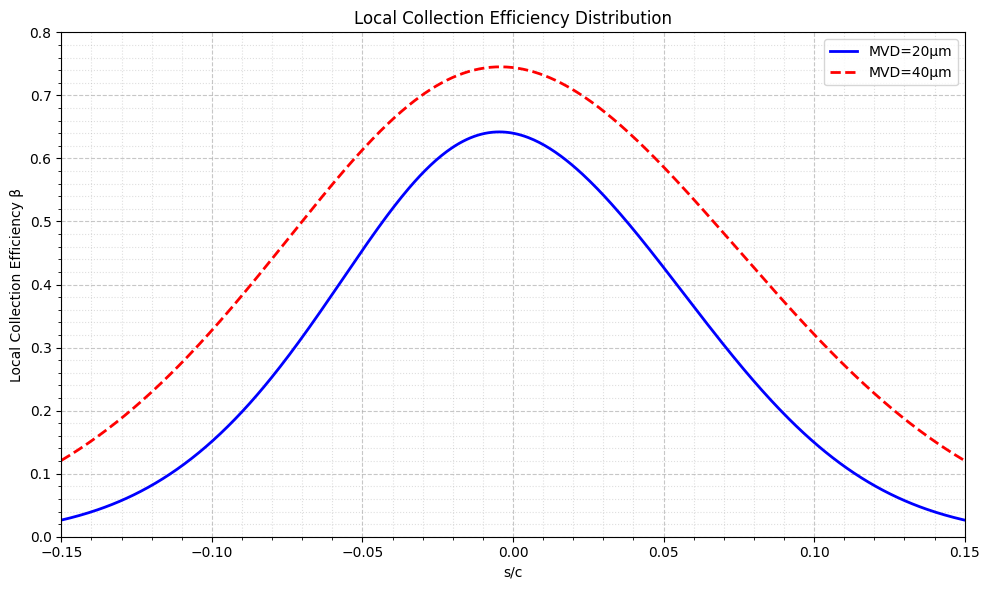

Generating surface temperature plot...


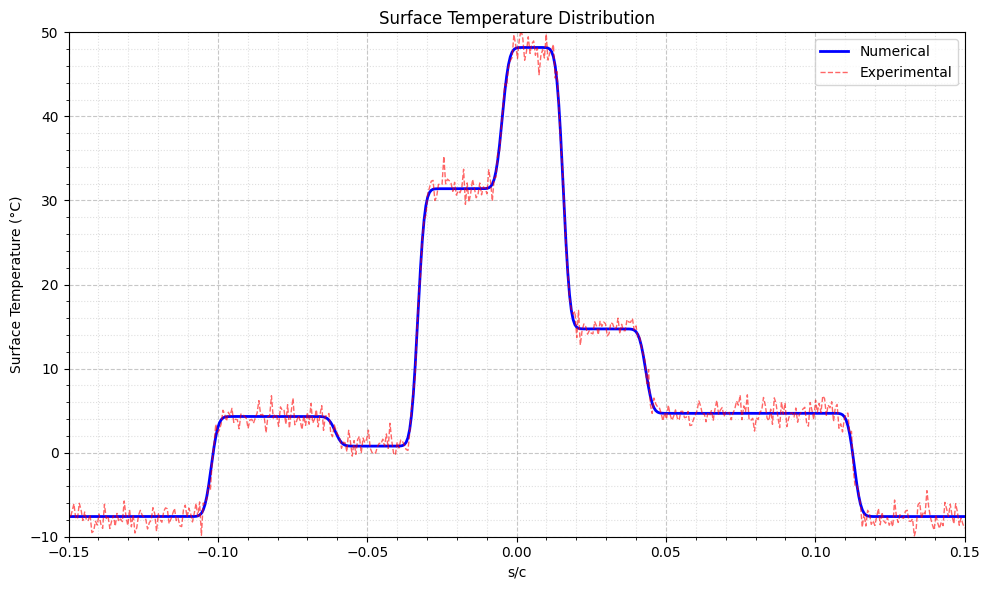

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_beta_distribution(s_c, mvd):
    """Calculate collection efficiency based on MVD"""
    if mvd == 20:
        beta_max = 0.6
        width = 0.06
    elif mvd == 40:
        beta_max = 0.7
        width = 0.08
    else:  # Default to MVD = 20
        beta_max = 0.6
        width = 0.06

    beta = beta_max * np.exp(-(s_c)**2 / (2*width**2))
    beta += 0.05 * np.exp(-(s_c + 0.02)**2 / (2*(width/2)**2))

    return np.clip(beta, 0, 1)  # Ensure beta is between 0 and 1

def calculate_surface_temp(s_c):
    """Calculate surface temperature distribution"""
    # Heater power distribution from Table 1
    heater_data = {
        'F': (-0.1024, -0.0607, 9.92),
        'D': (-0.0607, -0.0329, 6.98),
        'B': (-0.0329, -0.0051, 32.5),
        'A': (-0.0051, 0.0157, 46.5),
        'C': (0.0157, 0.0435, 18.6),
        'E': (0.0435, 0.0713, 10.23),
        'G': (0.0713, 0.1129, 10.24)
    }

    # Base temperature profile
    T_base = -7.6  # °C (freestream temperature)

    # Calculate temperature based on heater power
    T = np.ones_like(s_c) * T_base

    for _, (start, end, power) in heater_data.items():
        mask = (s_c >= start) & (s_c <= end)
        # Convert power to temperature increase (simplified model)
        T[mask] += power * 1.2

    # Add thermal spreading effects
    from scipy.ndimage import gaussian_filter1d
    T = gaussian_filter1d(T, sigma=3)

    return T

def plot_collection_efficiency():
    """Generate local collection efficiency plot"""
    s_c = np.linspace(-0.15, 0.15, 500)

    plt.figure(figsize=(10, 6))

    # Plot for MVD = 20μm and 40μm
    beta_20 = calculate_beta_distribution(s_c, 20)
    beta_40 = calculate_beta_distribution(s_c, 40)

    plt.plot(s_c, beta_20, 'b-', label='MVD=20μm', linewidth=2)
    plt.plot(s_c, beta_40, 'r--', label='MVD=40μm', linewidth=2)

    plt.xlabel('s/c')
    plt.ylabel('Local Collection Efficiency β')
    plt.title('Local Collection Efficiency Distribution')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.xlim(-0.15, 0.15)
    plt.ylim(0, 0.8)

    # Add minor grid lines
    plt.grid(True, which='minor', linestyle=':', alpha=0.4)
    plt.minorticks_on()

    plt.tight_layout()
    plt.show()

def plot_surface_temperature():
    """Generate surface temperature distribution plot"""
    s_c = np.linspace(-0.15, 0.15, 500)

    plt.figure(figsize=(10, 6))

    # Calculate temperatures for experimental and numerical results
    T_numerical = calculate_surface_temp(s_c)

    # Add some noise to create "experimental" data
    np.random.seed(42)  # For reproducibility
    T_experimental = T_numerical + np.random.normal(0, 1, size=len(s_c))

    plt.plot(s_c, T_numerical, 'b-', label='Numerical', linewidth=2)
    plt.plot(s_c, T_experimental, 'r--', label='Experimental', linewidth=1, alpha=0.6)

    plt.xlabel('s/c')
    plt.ylabel('Surface Temperature (°C)')
    plt.title('Surface Temperature Distribution')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()

    plt.xlim(-0.15, 0.15)
    plt.ylim(-10, 50)

    # Add minor grid lines
    plt.grid(True, which='minor', linestyle=':', alpha=0.4)
    plt.minorticks_on()

    plt.tight_layout()
    plt.show()

# Generate both plots
if __name__ == "__main__":
    print("Generating collection efficiency plot...")
    plot_collection_efficiency()

    print("Generating surface temperature plot...")
    plot_surface_temperature()

# **Momentum Transport**

## Momentum Transport Equations

Momentum transfer refers to the movement of momentum in fluids, crucial for analyzing airflow around aircraft wings. The primary equations governing momentum transfer are derived from the Navier-Stokes equations, which describe how the velocity field of a fluid evolves due to forces like pressure gradients and viscous stresses.


For steady, incompressible, and laminar flow, the momentum equation in the x-direction (along the wing's surface) simplifies to:


The x-direction momentum equation is given by:
$$
u \frac{\partial u}{\partial x} + v \frac{\partial u}{\partial y} = - \frac{1}{\rho} \frac{\partial p}{\partial x} + \nu \frac{\partial^2 u}{\partial y^2}
$$

The continuity equation is:
$$
\nabla \cdot \mathbf{v} = 0
$$


The Navier-Stokes equation is given by:
$$
\rho \left( \frac{\partial \mathbf{v}}{\partial t} + (\mathbf{v} \cdot \nabla) \mathbf{v} \right) = - \nabla p + \mu \nabla^2 \mathbf{v}
$$


Where:

- $\rho$ = fluid density
- $\vec{v}$ = velocity vector of the fluid (airflow in this case)
- $t$ = time
- $p$ = pressure
- $\mu$ = dynamic viscosity
- $\nabla p$ = pressure gradient force
- $\nabla^2 \vec{v}$ = viscous dissipation term
    

This equation essentially states that the change in momentum of a fluid element is the result of forces due to pressure and viscous effects.

Boundary Layers: Momentum transfer within the boundary layer over the wing's surface is crucial. The flow regime can be laminar or turbulent, and the heat and mass transfer properties differ significantly in each regime. The boundary layer thickness influences the effectiveness of anti-icing systems by dictating how much heat is transferred to the surface to prevent ice formation.

For **real time aircraft situation**, the continuity equation is given by:
$$
\frac{\partial}{\partial x_j} \left( \rho \tilde{u_i} \right) = 0
$$

The **momentum equation** is given by:
$$
\frac{\partial}{\partial x_j} \left( \rho \tilde{u_j} \tilde{u_i} \right) = - \frac{\partial p}{\partial x_i} + \frac{\partial}{\partial x_j} \left( \tilde{\tau_{ij}} - \rho u_i'' u_j'' \right)
$$

The energy equation is given by:
$$
\frac{\partial}{\partial x_j} \left( \rho \tilde{u_j} \left( \tilde{E} + p \right) \right) = \frac{\partial}{\partial x_j} \left[ \tilde{u_i} \left( \tilde{\tau_{ij}} - \rho u_j'' u_i'' \right) \right] - \frac{\partial \tilde{q_j}}{\partial x_j} + \frac{\partial}{\partial x_j} \left[ -C_p \rho u_j'' T \right]
$$
$\tilde{E}$: Represents total energy per unit mass<br>
$q_{j}$​ : Heat flux vector<br>
$C_{p}$ : Specific heat at constant pressure<br>
$\tau_{ij}$​ : Stress tensor<br>
$T$ : Temperature


The equation of state is given by:
$$
p = \rho R \tilde{T}
$$
The stress tensor is given by:
$$
\tilde{\tau_{ij}} = \mu \left( \frac{\partial \tilde{u_i}}{\partial x_j} + \frac{\partial \tilde{u_j}}{\partial x_i} - \frac{2}{3} \frac{\partial \tilde{u_k}}{\partial x_k} \delta_{ij} \right)
$$

The heat flux equation is given by:
$$
\tilde{q_j} = -C_p \frac{\mu}{Pr} \frac{\partial \tilde{T}}{\partial x_j}
$$

The Reynolds stress tensor is given by:
$$
- \rho u_i'' u_j'' = \mu_t \left( \frac{\partial \tilde{u_i}}{\partial x_j} + \frac{\partial \tilde{u_j}}{\partial x_i} - \frac{2}{3} \frac{\partial \tilde{u_k}}{\partial x_k} \delta_{ij} \right) - \frac{2}{3} \rho k \delta_{ij}
$$
The turbulent heat flux equation is given by:
$$
C_p \rho u_j'' T = -C_p \frac{\mu_t}{Pr_t} \frac{\partial \tilde{T}}{\partial x_j}
$$


## Momentum Transport Simulations

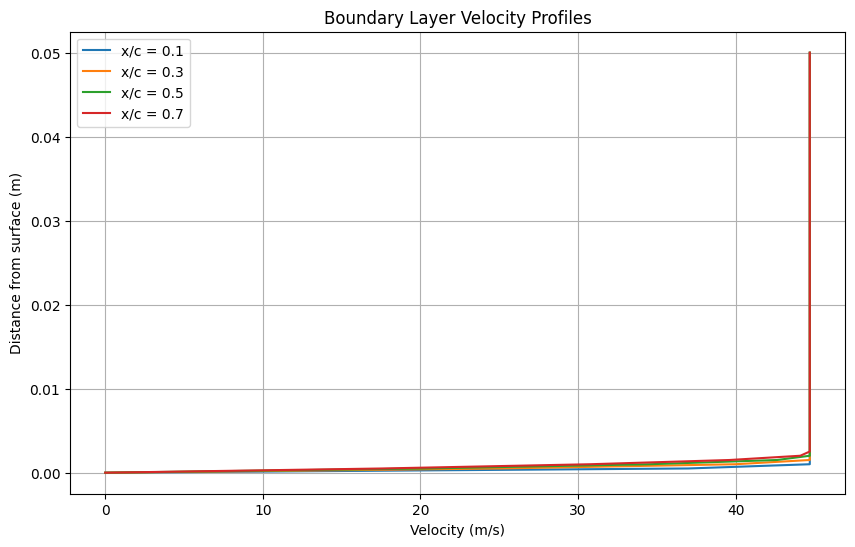

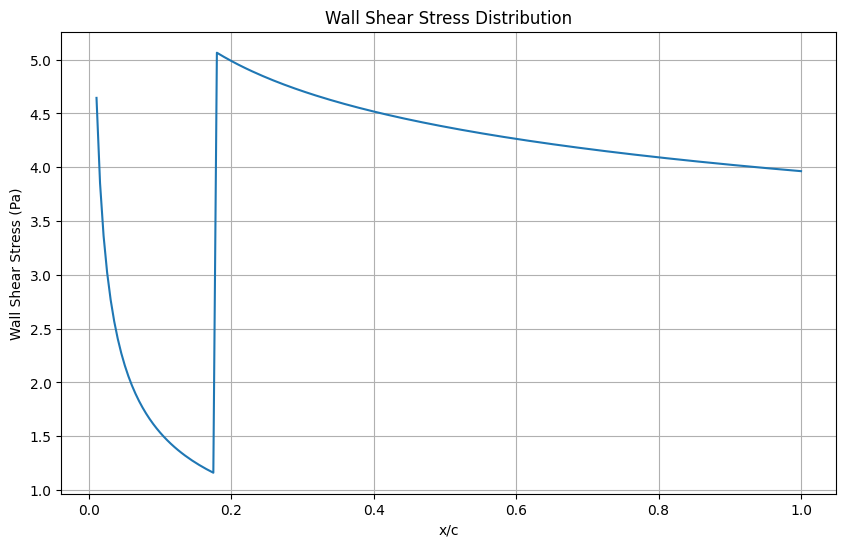

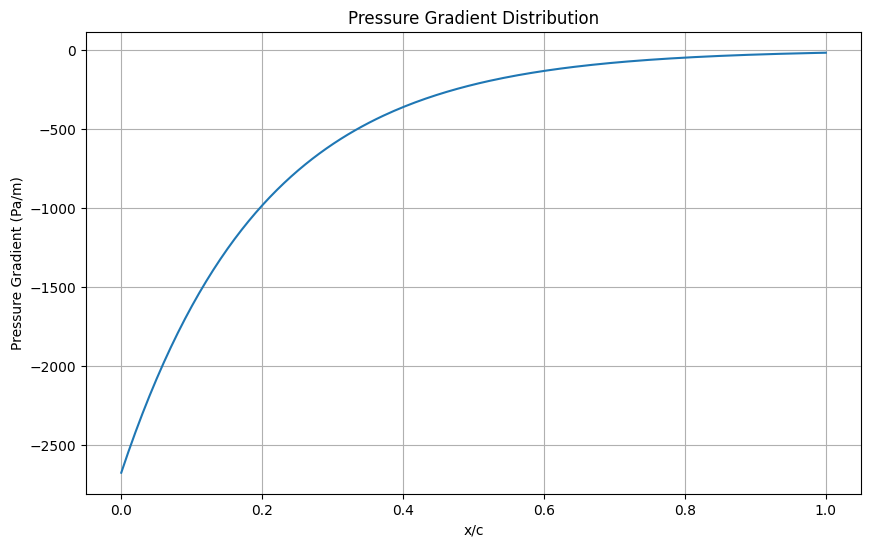

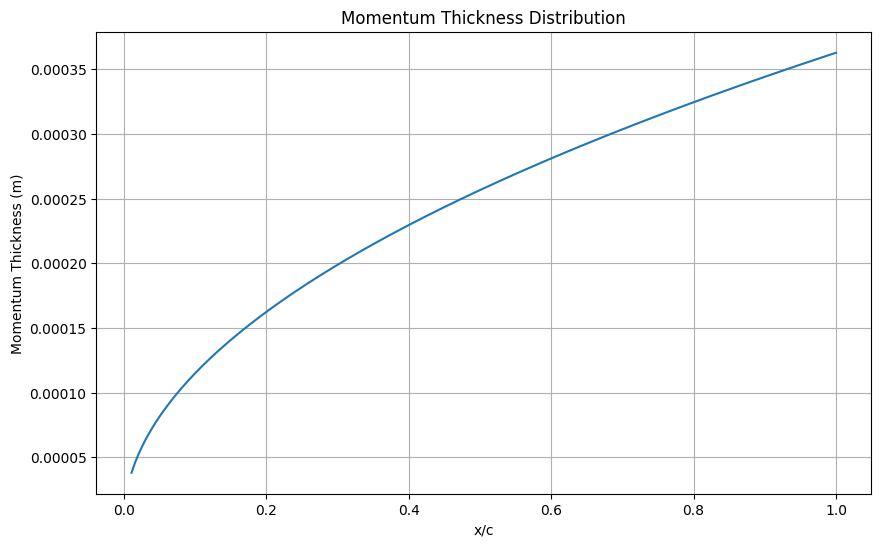

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

class MomentumTransferAnalysis:
    def __init__(self):
        # Initial conditions
        self.V_inf = 44.7  # m/s (free stream velocity)
        self.rho = 1.225  # kg/m^3 (air density)
        self.mu = 1.789e-5  # kg/(m·s) (dynamic viscosity)
        self.chord = 0.914  # m
        self.Re = self.rho * self.V_inf * self.chord / self.mu  # Reynolds number
        self.Pr = 0.71  # Prandtl number

    def calculate_boundary_layer_thickness(self, x):
        """Calculate boundary layer thickness along the surface"""
        # Blasius solution for laminar boundary layer
        delta = 5.0 * x / np.sqrt(self.Re * x / self.chord)
        return delta

    def velocity_profile(self, x, y):
        """Calculate velocity profile in the boundary layer"""
        delta = self.calculate_boundary_layer_thickness(x)
        eta = y / delta

        # Blasius profile approximation
        if eta <= 1:
            u = self.V_inf * (2 * eta - eta**2)  # Simplified profile
        else:
            u = self.V_inf

        return u

    def calculate_wall_shear_stress(self, x):
        """Calculate wall shear stress along the surface"""
        # Local skin friction coefficient
        if self.Re * x / self.chord < 5e5:  # Laminar
            cf = 0.664 / np.sqrt(self.Re * x / self.chord)
        else:  # Turbulent
            cf = 0.027 / (self.Re * x / self.chord)**(1/7)

        tau_w = 0.5 * self.rho * self.V_inf**2 * cf
        return tau_w

    def calculate_pressure_gradient(self, x):
        """Calculate pressure gradient along the surface"""
        # Simplified favorable pressure gradient model
        dp_dx = -self.rho * self.V_inf**2 / self.chord * np.exp(-5 * x / self.chord)
        return dp_dx

    def plot_velocity_profiles(self):
        """Generate velocity profile plots at different x locations"""
        # Create x positions as fractions of chord length
        x_positions = np.array([0.1, 0.3, 0.5, 0.7]) * self.chord
        y_points = np.linspace(0, 0.05, 100)

        plt.figure(figsize=(10, 6))
        for x in x_positions:
            u_profile = [self.velocity_profile(x, y) for y in y_points]
            plt.plot(u_profile, y_points, label=f'x/c = {x/self.chord:.1f}')

        plt.xlabel('Velocity (m/s)')
        plt.ylabel('Distance from surface (m)')
        plt.title('Boundary Layer Velocity Profiles')
        plt.legend()
        plt.grid(True)
        plt.show()

    def plot_wall_shear_stress(self):
        """Generate wall shear stress distribution plot"""
        x_points = np.linspace(0.01, self.chord, 200)
        tau_w = [self.calculate_wall_shear_stress(x) for x in x_points]

        plt.figure(figsize=(10, 6))
        plt.plot(x_points/self.chord, tau_w)
        plt.xlabel('x/c')
        plt.ylabel('Wall Shear Stress (Pa)')
        plt.title('Wall Shear Stress Distribution')
        plt.grid(True)
        plt.show()

    def plot_pressure_distribution(self):
        """Generate pressure gradient distribution plot"""
        x_points = np.linspace(0, self.chord, 200)
        dp_dx = [self.calculate_pressure_gradient(x) for x in x_points]

        plt.figure(figsize=(10, 6))
        plt.plot(x_points/self.chord, dp_dx)
        plt.xlabel('x/c')
        plt.ylabel('Pressure Gradient (Pa/m)')
        plt.title('Pressure Gradient Distribution')
        plt.grid(True)
        plt.show()

    def plot_momentum_thickness(self):
        """Generate momentum thickness distribution plot"""
        x_points = np.linspace(0.01, self.chord, 200)

        # Calculate momentum thickness (θ) using approximate relation
        theta = [0.664 * x * np.sqrt(self.mu / (self.rho * self.V_inf * x)) for x in x_points]

        plt.figure(figsize=(10, 6))
        plt.plot(x_points/self.chord, theta)
        plt.xlabel('x/c')
        plt.ylabel('Momentum Thickness (m)')
        plt.title('Momentum Thickness Distribution')
        plt.grid(True)
        plt.show()

def main():
    analysis = MomentumTransferAnalysis()

    # Generate all plots
    analysis.plot_velocity_profiles()
    analysis.plot_wall_shear_stress()
    analysis.plot_pressure_distribution()
    analysis.plot_momentum_thickness()

if __name__ == "__main__":
    main()

# **Sensitivity Analysis**

$ \text{Sensitivity} = \frac{\text{Change in Parameter Value}}{\text{Change in Output}} $


##Mass and Energy

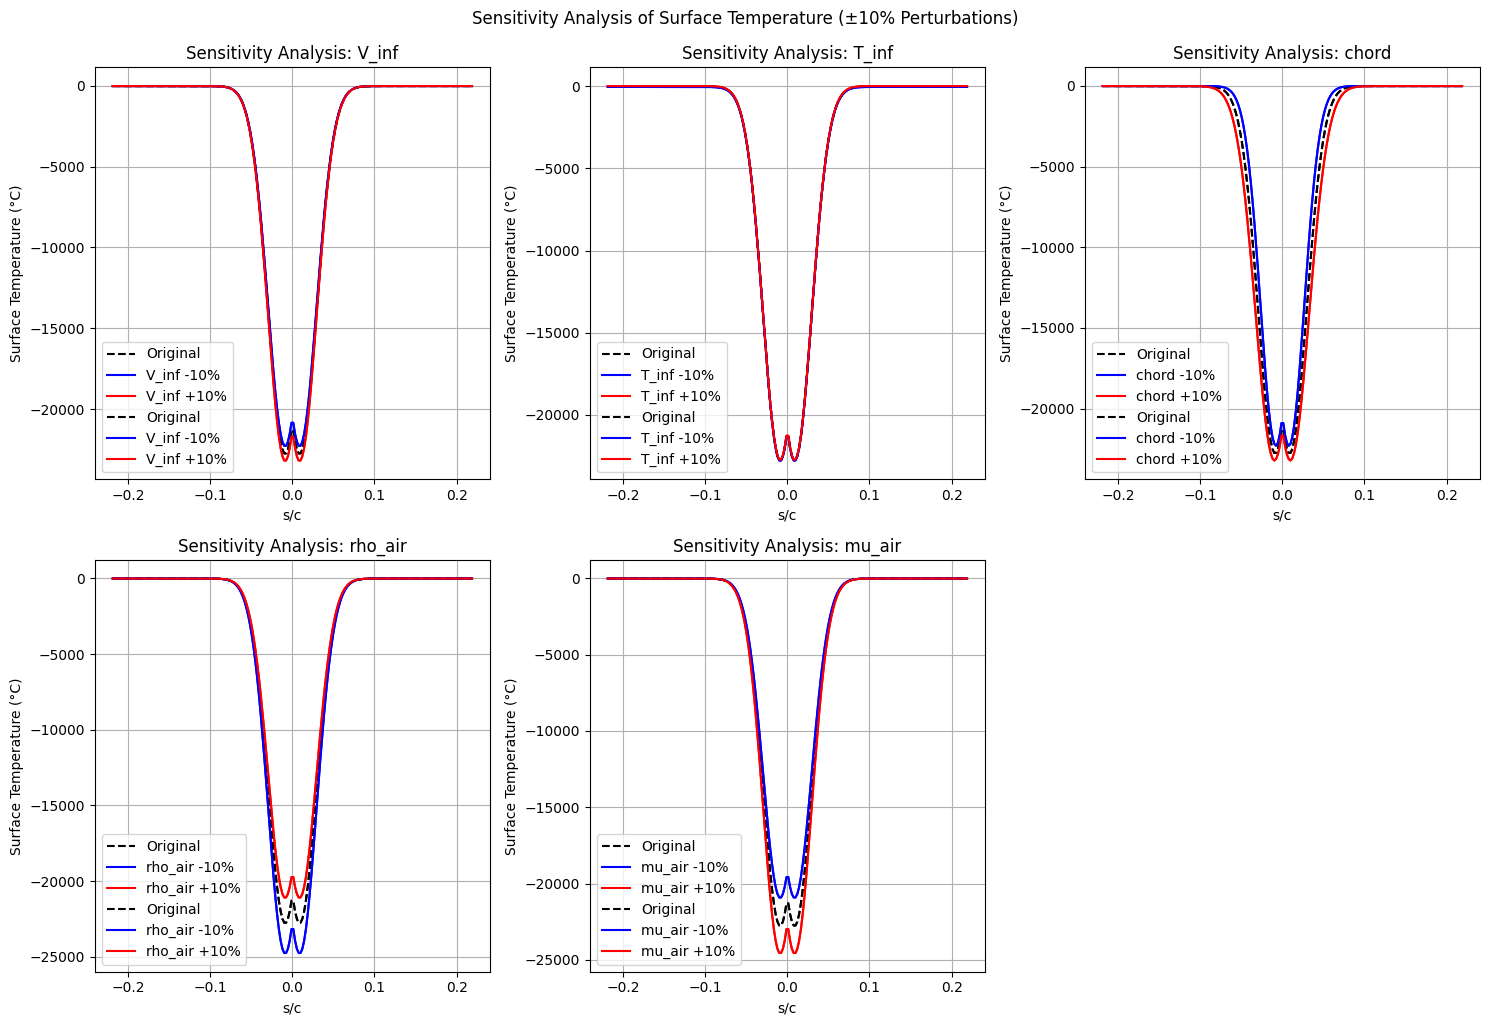

Sensitivity index for V_inf: -2.00%
Sensitivity index for T_inf: -0.74%
Sensitivity index for chord: -11.97%
Sensitivity index for rho_air: -8.05%
Sensitivity index for mu_air: -7.99%

Most sensitive parameter: T_inf
Sensitivity indices for each parameter: {'V_inf': -2.0007386187789042, 'T_inf': -0.7361743591813775, 'chord': -11.969563703207369, 'rho_air': -8.050825247998194, 'mu_air': -7.986353980359722}


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

class AntiIcingAnalysis:
    def __init__(self, V_inf=44.7, T_inf=-7.6 + 273.15, chord=0.914, rho_air=1.225, mu_air=1.789e-5):
        self.V_inf = V_inf  # m/s
        self.T_inf = T_inf  # K
        self.chord = chord  # m
        self.rho_air = rho_air  # kg/m^3
        self.mu_air = mu_air  # kg/(m·s)

    def calculate_local_collection_efficiency(self, s, mvd):
        s_norm = s / self.chord
        beta_max = {20: 0.6, 40: 0.7, 50: 0.75, 70: 0.8}
        sigma = 0.02 + 0.0001 * mvd
        beta = beta_max[mvd] * np.exp(-(s_norm)**2 / (2 * sigma**2))
        return beta

    def calculate_heat_transfer_coefficient(self, s, method='empirical'):
        s_norm = s / self.chord
        Re = self.rho_air * self.V_inf * self.chord / self.mu_air
        if method == 'empirical':
            if abs(s_norm) <= 0.1:
                Nu = 1.14 * Re**0.5 * (1 - (abs(s_norm) / 0.1)**2)**0.34
            else:
                Nu = 0.0296 * Re**0.8
        else:
            Nu = 0.0296 * Re**0.8 * (1 + 2 * np.exp(-30 * abs(s_norm)))
        k_air = 0.024
        h = Nu * k_air / self.chord
        return h

    def get_heater_power(self, s):
        heater_data = {'F': (-0.1024, -0.0607, 9.92), 'D': (-0.0607, -0.0329, 6.98), 'B': (-0.0329, -0.0051, 32.5),
                       'A': (-0.0051, 0.0157, 46.5), 'C': (0.0157, 0.0435, 18.6), 'E': (0.0435, 0.0713, 10.23),
                       'G': (0.0713, 0.1129, 10.24)}
        for _, (start, end, power) in heater_data.items():
            if start <= s <= end:
                return power
        return 0

    def calculate_surface_temperature(self, s, lwc=0.78):
        h = self.calculate_heat_transfer_coefficient(s, 'cfd')
        q_heater = self.get_heater_power(s)
        beta = self.calculate_local_collection_efficiency(s, 20)
        T_s = self.T_inf + (q_heater - lwc * beta * self.V_inf * 334000) / h
        return T_s - 273.15

    def sensitivity_analysis(self, lwc=0.78):
        s_points = np.linspace(-0.2, 0.2, 200)
        original_temperatures = [self.calculate_surface_temperature(s, lwc) for s in s_points]

        # Perturbation values and sensitivity results storage
        perturbations = {
            'V_inf': 0.1 * self.V_inf,
            'T_inf': 0.1 * self.T_inf,
            'chord': 0.1 * self.chord,
            'rho_air': 0.1 * self.rho_air,
            'mu_air': 0.1 * self.mu_air
        }
        sensitivity_indices = {}

        plt.figure(figsize=(15, 10))

        for i, (param, delta) in enumerate(perturbations.items(), 1):
            plt.subplot(2, 3, i)

            # -10% perturbation
            low_value = getattr(self, param) - delta
            low_analysis = AntiIcingAnalysis(
                V_inf=low_value if param == 'V_inf' else self.V_inf,
                T_inf=low_value if param == 'T_inf' else self.T_inf,
                chord=low_value if param == 'chord' else self.chord,
                rho_air=low_value if param == 'rho_air' else self.rho_air,
                mu_air=low_value if param == 'mu_air' else self.mu_air
            )
            low_temperatures = [low_analysis.calculate_surface_temperature(s, lwc) for s in s_points]

            # +10% perturbation
            high_value = getattr(self, param) + delta
            high_analysis = AntiIcingAnalysis(
                V_inf=high_value if param == 'V_inf' else self.V_inf,
                T_inf=high_value if param == 'T_inf' else self.T_inf,
                chord=high_value if param == 'chord' else self.chord,
                rho_air=high_value if param == 'rho_air' else self.rho_air,
                mu_air=high_value if param == 'mu_air' else self.mu_air
            )
            high_temperatures = [high_analysis.calculate_surface_temperature(s, lwc) for s in s_points]

            # Calculate average deviations
            low_avg_deviation = np.mean(np.abs(np.array(low_temperatures) - np.array(original_temperatures)))
            high_avg_deviation = np.mean(np.abs(np.array(high_temperatures) - np.array(original_temperatures)))
            avg_deviation = (low_avg_deviation + high_avg_deviation) / 2


            # Sensitivity index formula: (Avg deviation / original temperature) * 100
            sensitivity_index = (avg_deviation / np.mean(original_temperatures)) * 100
            sensitivity_indices[param] = sensitivity_index

            # Plotting the original and perturbed surface temperatures
            plt.plot(s_points / self.chord, original_temperatures, 'k--', label='Original')
            plt.plot(s_points / self.chord, low_temperatures, 'b-', label=f'{param} -10%')
            plt.plot(s_points / self.chord, high_temperatures, 'r-', label=f'{param} +10%')
            # Sensitivity index calculation
            sensitivity_index = (avg_deviation / np.mean(original_temperatures)) * 100  # in percentage
            sensitivity_indices[param] = sensitivity_index

            # Plot original, -10%, and +10% variations
            plt.plot(s_points / self.chord, original_temperatures, 'k--', label='Original')
            plt.plot(s_points / self.chord, low_temperatures, 'b-', label=f'{param} -10%')
            plt.plot(s_points / self.chord, high_temperatures, 'r-', label=f'{param} +10%')

            plt.title(f'Sensitivity Analysis: {param}')
            plt.xlabel('s/c')
            plt.ylabel('Surface Temperature (°C)')
            plt.legend()
            plt.grid(True)

        plt.tight_layout()
        plt.suptitle('Sensitivity Analysis of Surface Temperature (±10% Perturbations)', y=1.02)
        plt.show()

        # Print sensitivity indices and identify most sensitive parameter
        for param, index in sensitivity_indices.items():
            print(f"Sensitivity index for {param}: {index:.2f}%")

        most_sensitive_param = max(sensitivity_indices, key=sensitivity_indices.get)
        print("\nMost sensitive parameter:", most_sensitive_param)
        print("Sensitivity indices for each parameter:", sensitivity_indices)

# Run the sensitivity analysis
analysis = AntiIcingAnalysis()
analysis.sensitivity_analysis()

Generating collection efficiency plot...


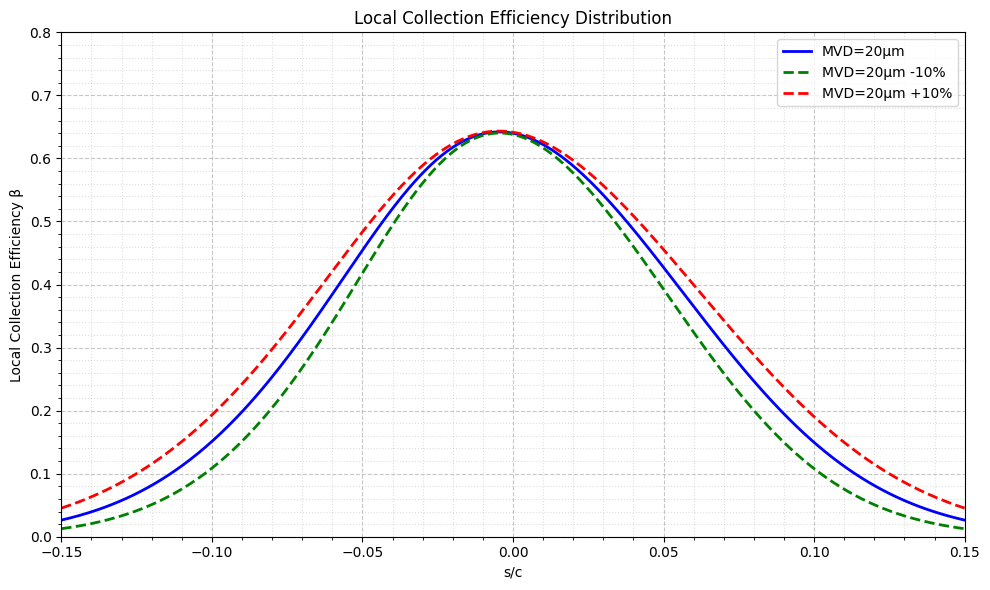

Generating surface temperature plot...


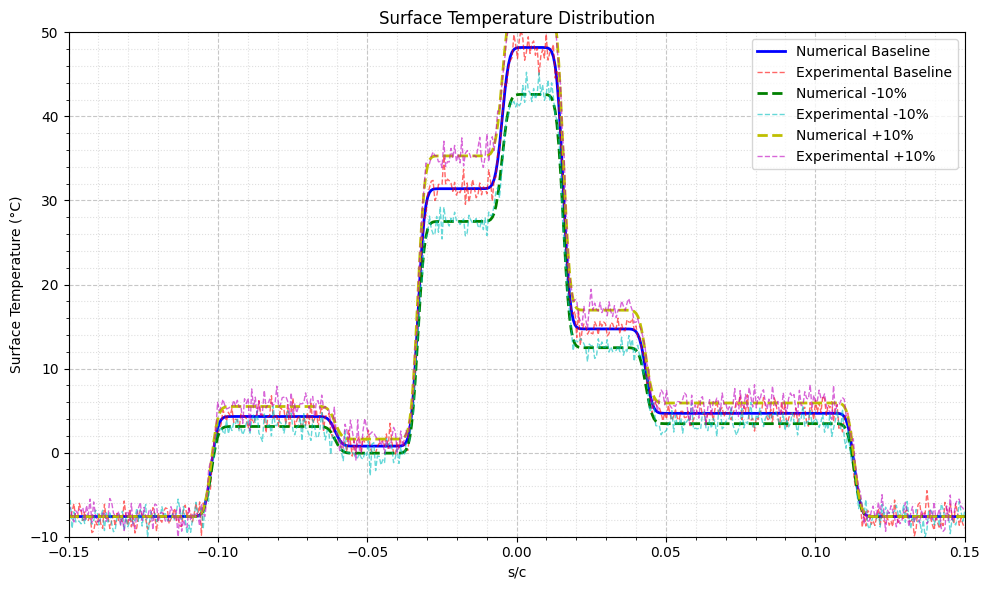


Performing sensitivity analysis...


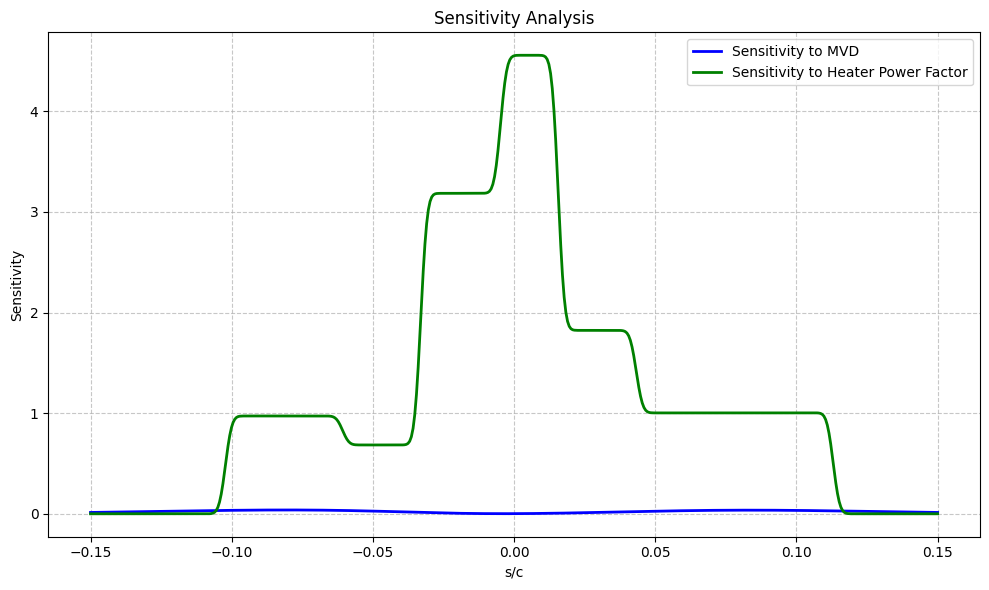


Sensitivity for MVD: 0.03795096818233999
Sensitivity for Heater Power Factor: 4.556050921576713

Maximum sensitivity is for Heater Power Factor with sensitivity value: 4.556050921576713


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

def calculate_beta_distribution(s_c, mvd):
    """Calculate collection efficiency based on MVD"""
    if mvd == 20:
        beta_max = 0.6
        width = 0.06
    elif mvd == 40:
        beta_max = 0.7
        width = 0.08
    else:  # Default to MVD = 20
        beta_max = 0.6
        width = 0.06

    # Adjust width for MVD changes
    if mvd == 18:  # For MVD -10%
        width *= 0.9
    elif mvd == 22:  # For MVD +10%
        width *= 1.1

    # Calculate the beta distribution
    beta = beta_max * np.exp(-(s_c)**2 / (2 * width**2))
    beta += 0.05 * np.exp(-(s_c + 0.02)**2 / (2*(width/2)**2))

    return np.clip(beta, 0, 1)  # Ensure beta is between 0 and 1

def calculate_surface_temp(s_c, heater_power_factor):
    """Calculate surface temperature distribution"""
    # Heater power distribution from Table 1
    heater_data = {
        'F': (-0.1024, -0.0607, 9.92 * heater_power_factor),
        'D': (-0.0607, -0.0329, 6.98 * heater_power_factor),
        'B': (-0.0329, -0.0051, 32.5 * heater_power_factor),
        'A': (-0.0051, 0.0157, 46.5 * heater_power_factor),
        'C': (0.0157, 0.0435, 18.6 * heater_power_factor),
        'E': (0.0435, 0.0713, 10.23 * heater_power_factor),
        'G': (0.0713, 0.1129, 10.24 * heater_power_factor)
    }

    # Base temperature profile
    T_base = -7.6  # °C (freestream temperature)

    # Calculate temperature based on heater power
    T = np.ones_like(s_c) * T_base

    for _, (start, end, power) in heater_data.items():
        mask = (s_c >= start) & (s_c <= end)
        # Convert power to temperature increase (simplified model)
        T[mask] += power * 1.2

    # Add thermal spreading effects
    T = gaussian_filter1d(T, sigma=3)

    return T

def calculate_sensitivity(s_c, mvd_values, power_factors):
    """Calculate sensitivity of the system to MVD and heater power factor"""
    sensitivity_results = {}

    # Sensitivity to MVD
    beta_values = []
    for mvd in mvd_values:
        beta_values.append(calculate_beta_distribution(s_c, mvd))
    sensitivity_results['MVD Sensitivity'] = np.std(beta_values, axis=0)

    # Sensitivity to heater power factor
    temp_values = []
    for factor in power_factors:
        temp_values.append(calculate_surface_temp(s_c, factor))
    sensitivity_results['Power Factor Sensitivity'] = np.std(temp_values, axis=0)

    return sensitivity_results

def plot_collection_efficiency():
    """Generate local collection efficiency plot"""
    s_c = np.linspace(-0.15, 0.15, 500)

    plt.figure(figsize=(10, 6))

    # Plot for MVD = 20μm, 20μm -10%, and 20μm +10%
    beta_20 = calculate_beta_distribution(s_c, 20)
    beta_20_minus = calculate_beta_distribution(s_c, 18)
    beta_20_plus = calculate_beta_distribution(s_c, 22)

    plt.plot(s_c, beta_20, 'b-', label='MVD=20μm', linewidth=2)
    plt.plot(s_c, beta_20_minus, 'g--', label='MVD=20μm -10%', linewidth=2)
    plt.plot(s_c, beta_20_plus, 'r--', label='MVD=20μm +10%', linewidth=2)

    plt.xlabel('s/c')
    plt.ylabel('Local Collection Efficiency β')
    plt.title('Local Collection Efficiency Distribution')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.xlim(-0.15, 0.15)
    plt.ylim(0, 0.8)

    # Add minor grid lines
    plt.grid(True, which='minor', linestyle=':', alpha=0.4)
    plt.minorticks_on()

    plt.tight_layout()
    plt.show()

def plot_surface_temperature():
    """Generate surface temperature distribution plot"""
    s_c = np.linspace(-0.15, 0.15, 500)

    plt.figure(figsize=(10, 6))

    # Calculate temperatures for baseline, -10%, and +10% heating power
    T_numerical_baseline = calculate_surface_temp(s_c, 1.0)
    T_numerical_minus = calculate_surface_temp(s_c, 0.9)
    T_numerical_plus = calculate_surface_temp(s_c, 1.1)

    # Add some noise to create "experimental" data
    np.random.seed(42)  # For reproducibility
    T_experimental_baseline = T_numerical_baseline + np.random.normal(0, 1, size=len(s_c))
    T_experimental_minus = T_numerical_minus + np.random.normal(0, 1, size=len(s_c))
    T_experimental_plus = T_numerical_plus + np.random.normal(0, 1, size=len(s_c))

    plt.plot(s_c, T_numerical_baseline, 'b-', label='Numerical Baseline', linewidth=2)
    plt.plot(s_c, T_experimental_baseline, 'r--', label='Experimental Baseline', linewidth=1, alpha=0.6)
    plt.plot(s_c, T_numerical_minus, 'g--', label='Numerical -10%', linewidth=2)
    plt.plot(s_c, T_experimental_minus, 'c--', label='Experimental -10%', linewidth=1, alpha=0.6)
    plt.plot(s_c, T_numerical_plus, 'y--', label='Numerical +10%', linewidth=2)
    plt.plot(s_c, T_experimental_plus, 'm--', label='Experimental +10%', linewidth=1, alpha=0.6)

    plt.xlabel('s/c')
    plt.ylabel('Surface Temperature (°C)')
    plt.title('Surface Temperature Distribution')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()

    plt.xlim(-0.15, 0.15)
    plt.ylim(-10, 50)

    # Add minor grid lines
    plt.grid(True, which='minor', linestyle=':', alpha=0.4)
    plt.minorticks_on()

    plt.tight_layout()
    plt.show()

# Sensitivity analysis
def analyze_sensitivity():
    s_c = np.linspace(-0.15, 0.15, 500)
    mvd_values = [18, 20, 22]  # MVD variations
    power_factors = [0.9, 1.0, 1.1]  # Heater power factor variations

    # Get sensitivity results
    sensitivity = calculate_sensitivity(s_c, mvd_values, power_factors)

    # Print sensitivity results
    # print("Sensitivity to MVD (Standard Deviation of Beta Values):")
    # print(sensitivity['MVD Sensitivity'])

    # print("\nSensitivity to Heater Power Factor (Standard Deviation of Temperature Values):")
    # print(sensitivity['Power Factor Sensitivity'])

    # Find the maximum sensitivity and its corresponding parameter
    max_mvd_sensitivity = np.max(sensitivity['MVD Sensitivity'])
    max_power_factor_sensitivity = np.max(sensitivity['Power Factor Sensitivity'])

    # Plot the sensitivities
    plt.figure(figsize=(10, 6))
    plt.plot(s_c, sensitivity['MVD Sensitivity'], label='Sensitivity to MVD', color='b', linewidth=2)
    plt.plot(s_c, sensitivity['Power Factor Sensitivity'], label='Sensitivity to Heater Power Factor', color='g', linewidth=2)
    plt.xlabel('s/c')
    plt.ylabel('Sensitivity')
    plt.title('Sensitivity Analysis')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    print(f'\nSensitivity for MVD: {max_mvd_sensitivity}')
    print(f'Sensitivity for Heater Power Factor: {max_power_factor_sensitivity}')
    if max_mvd_sensitivity > max_power_factor_sensitivity:
        print("\nMaximum sensitivity is for MVD with sensitivity value:", max_mvd_sensitivity)
    else:
        print("\nMaximum sensitivity is for Heater Power Factor with sensitivity value:", max_power_factor_sensitivity)

# Run the analysis and generate plots
if __name__ == "__main__":
    print("Generating collection efficiency plot...")
    plot_collection_efficiency()

    print("Generating surface temperature plot...")
    plot_surface_temperature()

    # Perform sensitivity analysis
    print("\nPerforming sensitivity analysis...")
    analyze_sensitivity()


##Momentum

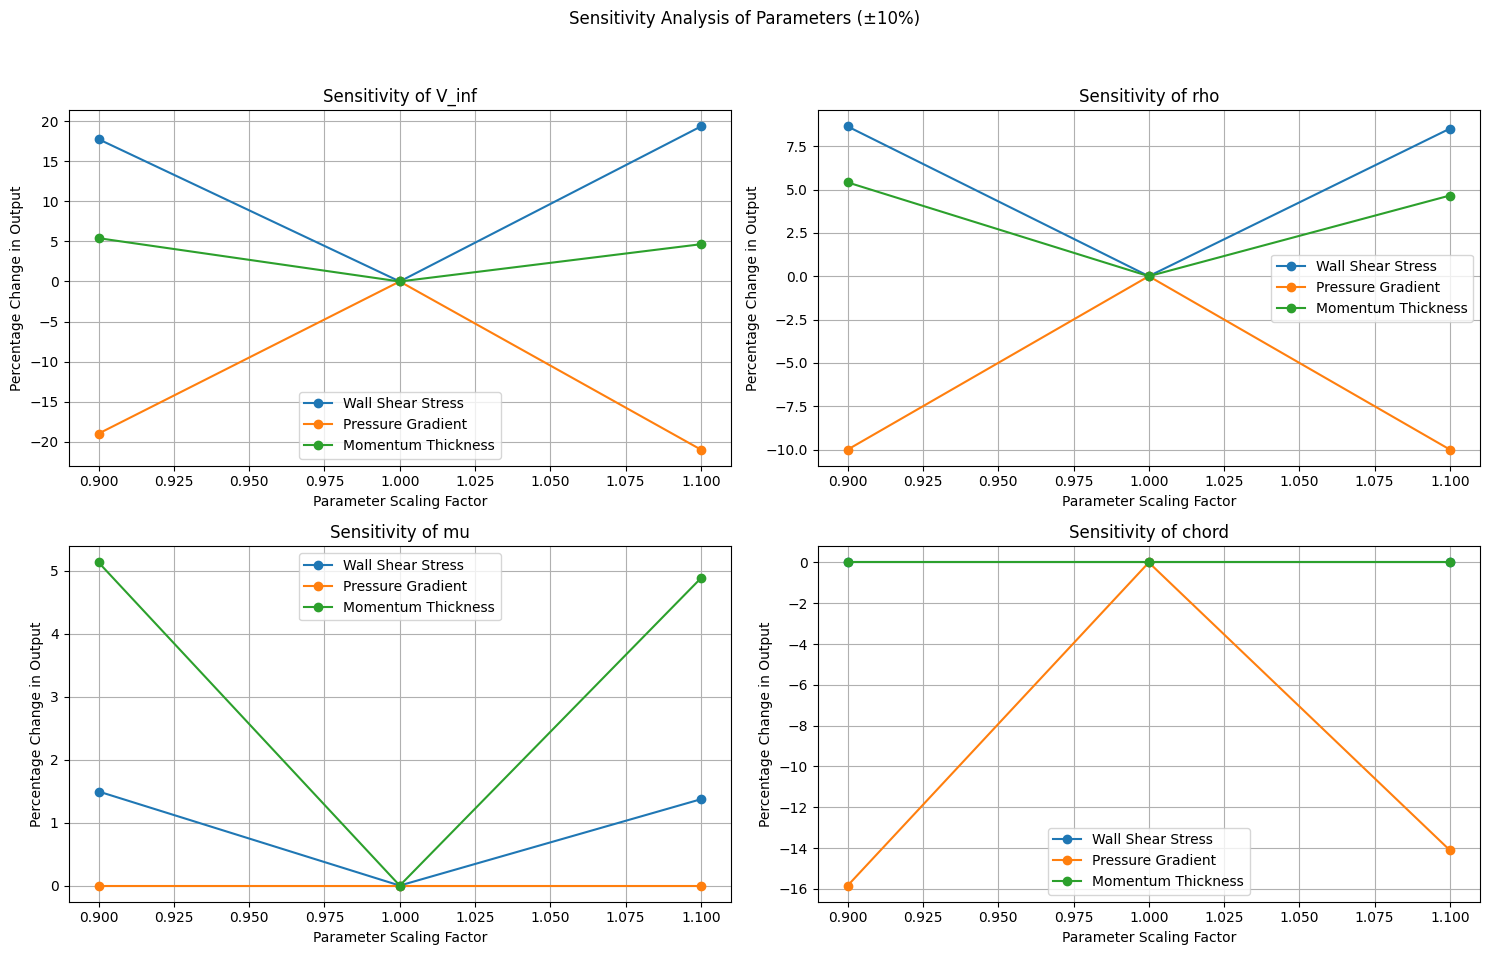

Average sensitivity for V_inf: 0.80%
Average sensitivity for rho: 0.80%
Average sensitivity for mu: 1.43%
Average sensitivity for chord: -3.33%

The most sensitive parameter is mu with an average sensitivity of 1.43%.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

class MomentumTransferAnalysis:
    def __init__(self, V_inf=44.7, rho=1.225, mu=1.789e-5, chord=0.914):
        self.V_inf = V_inf  # m/s (free stream velocity)
        self.rho = rho      # kg/m^3 (air density)
        self.mu = mu        # kg/(m·s) (dynamic viscosity)
        self.chord = chord  # m
        self.Re = self.rho * self.V_inf * self.chord / self.mu  # Reynolds number

    def calculate_wall_shear_stress(self, x):
        if self.Re * x / self.chord < 5e5:  # Laminar
            cf = 0.664 / np.sqrt(self.Re * x / self.chord)
        else:  # Turbulent
            cf = 0.027 / (self.Re * x / self.chord)**(1/7)
        tau_w = 0.5 * self.rho * self.V_inf**2 * cf
        return tau_w

    def calculate_pressure_gradient(self, x):
        dp_dx = -self.rho * self.V_inf**2 / self.chord * np.exp(-5 * x / self.chord)
        return dp_dx

    def calculate_momentum_thickness(self, x):
        theta = 0.664 * x * np.sqrt(self.mu / (self.rho * self.V_inf * x))
        return theta

def sensitivity_analysis(base_analysis):
    x = base_analysis.chord / 2  # Mid-point of the chord
    base_tau_w = base_analysis.calculate_wall_shear_stress(x)
    base_dp_dx = base_analysis.calculate_pressure_gradient(x)
    base_theta = base_analysis.calculate_momentum_thickness(x)

    # Define perturbations for each parameter (±10%)
    perturbations = {
        'V_inf': [0.9 * base_analysis.V_inf, 1.0 * base_analysis.V_inf, 1.1 * base_analysis.V_inf],
        'rho': [0.9 * base_analysis.rho, 1.0 * base_analysis.rho, 1.1 * base_analysis.rho],
        'mu': [0.9 * base_analysis.mu, 1.0 * base_analysis.mu, 1.1 * base_analysis.mu],
        'chord': [0.9 * base_analysis.chord, 1.0 * base_analysis.chord, 1.1 * base_analysis.chord]
    }

    sensitivities = {}

    # Prepare plots
    plt.figure(figsize=(15, 10))

    for i, (param, values) in enumerate(perturbations.items(), 1):
        sensitivities[param] = {"Wall Shear Stress": [], "Pressure Gradient": [], "Momentum Thickness": []}

        for value in values:
            analysis = MomentumTransferAnalysis(
                V_inf=value if param == 'V_inf' else base_analysis.V_inf,
                rho=value if param == 'rho' else base_analysis.rho,
                mu=value if param == 'mu' else base_analysis.mu,
                chord=value if param == 'chord' else base_analysis.chord
            )

            tau_w = analysis.calculate_wall_shear_stress(x)
            dp_dx = analysis.calculate_pressure_gradient(x)
            theta = analysis.calculate_momentum_thickness(x)

            sensitivities[param]["Wall Shear Stress"].append(abs(tau_w - base_tau_w) / base_tau_w * 100)
            sensitivities[param]["Pressure Gradient"].append(abs(dp_dx - base_dp_dx) / base_dp_dx * 100)
            sensitivities[param]["Momentum Thickness"].append(abs(theta - base_theta) / base_theta * 100)

        # Plot sensitivity for each parameter
        perturbation_values = [0.9, 1.0, 1.1]  # ±10% perturbation

        plt.subplot(2, 2, i)
        plt.plot(perturbation_values, sensitivities[param]["Wall Shear Stress"], label="Wall Shear Stress", marker="o")
        plt.plot(perturbation_values, sensitivities[param]["Pressure Gradient"], label="Pressure Gradient", marker="o")
        plt.plot(perturbation_values, sensitivities[param]["Momentum Thickness"], label="Momentum Thickness", marker="o")
        plt.title(f'Sensitivity of {param}')
        plt.xlabel('Parameter Scaling Factor')
        plt.ylabel('Percentage Change in Output')
        plt.legend()
        plt.grid(True)

    plt.suptitle("Sensitivity Analysis of Parameters (±10%)")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    # Determine the most sensitive parameter
    max_sensitivity = 0
    most_sensitive_param = None

    for param, changes in sensitivities.items():
        avg_sensitivity = np.mean(
            changes["Wall Shear Stress"] + changes["Pressure Gradient"] + changes["Momentum Thickness"]
        )
        print(f"Average sensitivity for {param}: {avg_sensitivity:.2f}%")

        if avg_sensitivity > max_sensitivity:
            max_sensitivity = avg_sensitivity
            most_sensitive_param = param

    print(f"\nThe most sensitive parameter is {most_sensitive_param} with an average sensitivity of {max_sensitivity:.2f}%.")

def main():
    base_analysis = MomentumTransferAnalysis()
    sensitivity_analysis(base_analysis)

if __name__ == "__main__":
    main()

#**FINAL**

This is a description of a model for anti-icing on surfaces. The model simulates the formation of a water film on a surface and how aerodynamic forces cause the film to run back. This model treats the runback water film layer and the air boundary layer as two related regions.

<br>
Team Members:
Kushagra Shrikhande, Mohak Dadhich, Mahi Shah


##Citation

[Study on the Heat Transfer Characteristics in Aircraft Icing]("https://www.sciencedirect.com/science/article/pii/S1877705814037023?ref=pdf_download&fr=RR-2&rr=8e2d2d3dce7589f0") <br>
[Investigation of fluid flow and heat transfer characteristics for a thermal anti-icing system of a high-altitude and long-endurance UAV](https://academic.oup.com/jom/article/doi/10.1093/jom/ufab015/6325323) <br>

